# This notebook seeks to Answer
* How do classifier (e.g.: linear probe) transfer between different types of attacks?

In [1]:
from pathlib import Path
import os
# Get the current working directory (where the notebook is)
notebook_dir = Path.cwd()

# Move up to the root directory (parent of 'notebooks')
project_root = notebook_dir.parent.parent
os.chdir(project_root)


In [2]:
import pandas as pd
import sys
import os
import numpy as np
from pathlib import Path

In [3]:
from analysis.unsupervised import *
from analysis.supervised import *

In [4]:
## Load rated dataset 
wild_jailbreak_path = project_root/ "datasets/latest/wildJailBreak_rated.pkl"

wei_gemma7bit = project_root / "datasets/latest/gemma-7b-it_wei_three_new_rated_merged.pkl"

wei_llama8bit = project_root / "datasets/_meta-llamaLlama-3.1-8B-Instruct_prompt_res_activations_2911202410:07:48_rated.pkl"


path = [wild_jailbreak_path, wei_gemma7bit, wei_llama8bit][2]

df = pd.read_pickle(path)

path = str(path)

In [5]:
## CONFIG
models = {
    "gemma-7b-it": {
        "num_layers": 28,
        "rating_column": "rating",
    },
    "Llama-3.1-8B-Instruct": {
        "num_layers": 32,
        "rating_column": "rating_output_text",
    },
    "Llama-3.2-3b-Instruct": {
        "num_layers": 28,
        "rating_column": "rating_output_text",       
    }
}

# Determine the model name based on the file path
def get_model_name(path):
    for model_name in models.keys():
        if model_name in str(path):
            return model_name, models[model_name]["num_layers"], models[model_name]["rating_column"]
    return "unknown"  # Default if no match is found

model_name, num_layers, rating_column = get_model_name(path)

layer= num_layers - 4
activation_column="prompt_res_activations"
num_samples = len(df)
dataset_name = "wildJailBreak" if "wildJailBreak" in str(path) else "wei_dataset"

In [6]:
# # PERCENTILE CUTOFF
# rating_column = ["rating", "rating_output_text"][1]
# # Calculate ASR for each jailbreak_prompt_name
# asr_values = []

# for jailbreak_prompt in df['jailbreak_prompt_name'].unique():
#     # Calculate normalized value counts for each prompt
#     ASR = df[df['jailbreak_prompt_name'] == jailbreak_prompt][rating_column].value_counts(normalize=True)
#     if "Yes" in ASR:  # Only consider prompts with "Yes" success rates
#         asr_values.append(ASR["Yes"])

# # Calculate the 90th percentile cutoff
# percentile = 50
# percentile_cutoff = np.percentile(asr_values, percentile)
# print(f"{percentile}th Percentile Cutoff for ASR: {percentile_cutoff}")

# # Collect successful jailbreak_prompt_names above the 90th percentile
# successful_jailbreaks = []

# for jailbreak_prompt in df['jailbreak_prompt_name'].unique():
#     ASR = df[df['jailbreak_prompt_name'] == jailbreak_prompt][rating_column].value_counts(normalize=True)
#     # Check conditions: ASR["Yes"] exists and exceeds the 90th percentile
#     if "Yes" in ASR and ASR["Yes"] > percentile_cutoff:
#         successful_jailbreaks.append(jailbreak_prompt)

# # Filter the dataframe to keep only rows matching the criteria or the 'original_prompt'
# df = df[(df['jailbreak_prompt_name'].isin(successful_jailbreaks)) | (df['jailbreak_prompt_name'] == 'original_prompt')]

# # Display the count of remaining jailbreak_prompt_name values
# print(df["jailbreak_prompt_name"].value_counts())


In [7]:
## TOP 10 JAILBREAK PROMPTS
import numpy as np

# Calculate ASR (Accuracy Success Rate) for each jailbreak_prompt_name
asr_values = []

# Calculate the ASR for each jailbreak prompt
for jailbreak_prompt in df['jailbreak_prompt_name'].unique():
    # Calculate normalized value counts for each prompt
    ASR = df[df['jailbreak_prompt_name'] == jailbreak_prompt][rating_column].value_counts(normalize=True)
    if "Yes" in ASR:  # Only consider prompts with "Yes" success rates
        asr_values.append((jailbreak_prompt, ASR["Yes"]))

# Sort the ASR values in descending order and select the top 10
top_10_jailbreaks = sorted(asr_values, key=lambda x: x[1], reverse=True)[:10]

# Extract the top 10 jailbreak prompt names
top_10_jailbreak_prompt_names = [item[0] for item in top_10_jailbreaks]

# Filter the dataframe to keep only rows matching the top 10 jailbreak prompts or the 'original_prompt'
df = df[(df['jailbreak_prompt_name'].isin(top_10_jailbreak_prompt_names)) | (df['jailbreak_prompt_name'] == 'original_prompt')]

# Display the count of remaining jailbreak_prompt_name values
print(df["jailbreak_prompt_name"].value_counts())



jailbreak_prompt_name
original_prompt          600
autodan                  300
wikipedia                300
AIM                      300
style_injection_json     300
style_injection_short    300
refusal_suppression      300
dev_mode_v2              300
prefix_injection         300
wikipedia_with_title     300
Name: count, dtype: int64


## Linear Probe

In [8]:
def extract_layer(row, layer):
    return row['prompt_res_activations'][layer][0].cpu().numpy().flatten()

In [9]:
# Add column that has 0 if "rating" is "No" and 1 if "rating" is "Yes"
df['rating_binary'] = df[rating_column].apply(lambda x: 0 if x == "No" else 1)

# Create new columns for each layer
df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)


In [10]:
results_df = probe_transfer(df, "logistic_regression", layer = layer)

results_df

rating_binary
0    248
1    248
Name: count, dtype: int64
rating_binary
1    70
0    70
Name: count, dtype: int64
rating_binary
0    145
1    145
Name: count, dtype: int64
rating_binary
0    4
1    4
Name: count, dtype: int64
rating_binary
1    134
0    134
Name: count, dtype: int64
rating_binary
0    134
1    134
Name: count, dtype: int64
rating_binary
1    144
0    144
Name: count, dtype: int64
rating_binary
0    23
1    23
Name: count, dtype: int64
rating_binary
1    139
0    139
Name: count, dtype: int64
rating_binary
1    133
0    133
Name: count, dtype: int64


,original_prompt,autodan,wikipedia,AIM,style_injection_json,style_injection_short,refusal_suppression,dev_mode_v2,prefix_injection,wikipedia_with_title
original_prompt,0.93,0.642857,0.637931,0.0,0.5,0.555556,0.603448,0.5,0.5,0.62963
autodan,0.43,0.714286,0.396552,0.5,0.592593,0.462963,0.517241,0.5,0.571429,0.555556
wikipedia,0.68,0.392857,0.672414,0.5,0.537037,0.518519,0.534483,0.5,0.571429,0.574074
AIM,0.5,0.5,0.465517,0.0,0.574074,0.462963,0.568966,0.8,0.535714,0.574074
style_injection_json,0.49,0.392857,0.551724,0.5,0.759259,0.351852,0.396552,0.6,0.5,0.481481
style_injection_short,0.54,0.428571,0.568966,0.5,0.518519,0.833333,0.689655,0.4,0.571429,0.5
refusal_suppression,0.64,0.535714,0.568966,0.5,0.555556,0.62963,0.724138,0.5,0.482143,0.685185
dev_mode_v2,0.47,0.321429,0.517241,0.0,0.518519,0.444444,0.448276,0.8,0.464286,0.648148
prefix_injection,0.56,0.678571,0.689655,0.5,0.425926,0.462963,0.5,0.7,0.821429,0.518519
wikipedia_with_title,0.68,0.535714,0.655172,1.0,0.5,0.481481,0.551724,0.5,0.428571,0.722222


In [11]:
results_df.describe()

,original_prompt,autodan,wikipedia,AIM,style_injection_json,style_injection_short,refusal_suppression,dev_mode_v2,prefix_injection,wikipedia_with_title
count,10.00,10.000000,10.000000,10.0,10.0,10.000000,10.000000,10.0,10.000000,10.000000
unique,9.00,8.000000,9.000000,3.0,8.0,8.000000,10.000000,5.0,7.000000,9.000000
top,0.68,0.392857,0.568966,0.5,0.5,0.462963,0.603448,0.5,0.571429,0.574074
freq,2.00,2.000000,2.000000,6.0,2.0,3.000000,1.000000,5.0,3.000000,2.000000


In [12]:
results_df.mean()

original_prompt             0.592
autodan                  0.514286
wikipedia                0.572414
AIM                           0.4
style_injection_json     0.548148
style_injection_short     0.52037
refusal_suppression      0.553448
dev_mode_v2                  0.58
prefix_injection         0.544643
wikipedia_with_title     0.588889
dtype: object

In [13]:
results_df.mean(axis=1)


original_prompt          0.549942
autodan                  0.524062
wikipedia                0.548081
AIM                      0.498131
style_injection_json     0.502373
style_injection_short    0.555047
refusal_suppression      0.582133
dev_mode_v2              0.463234
prefix_injection         0.585706
wikipedia_with_title     0.605489
dtype: object

In [14]:
results_df.mean(axis=0)

original_prompt             0.592
autodan                  0.514286
wikipedia                0.572414
AIM                           0.4
style_injection_json     0.548148
style_injection_short     0.52037
refusal_suppression      0.553448
dev_mode_v2                  0.58
prefix_injection         0.544643
wikipedia_with_title     0.588889
dtype: object

/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:535: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  results_df = results_df.fillna(0)


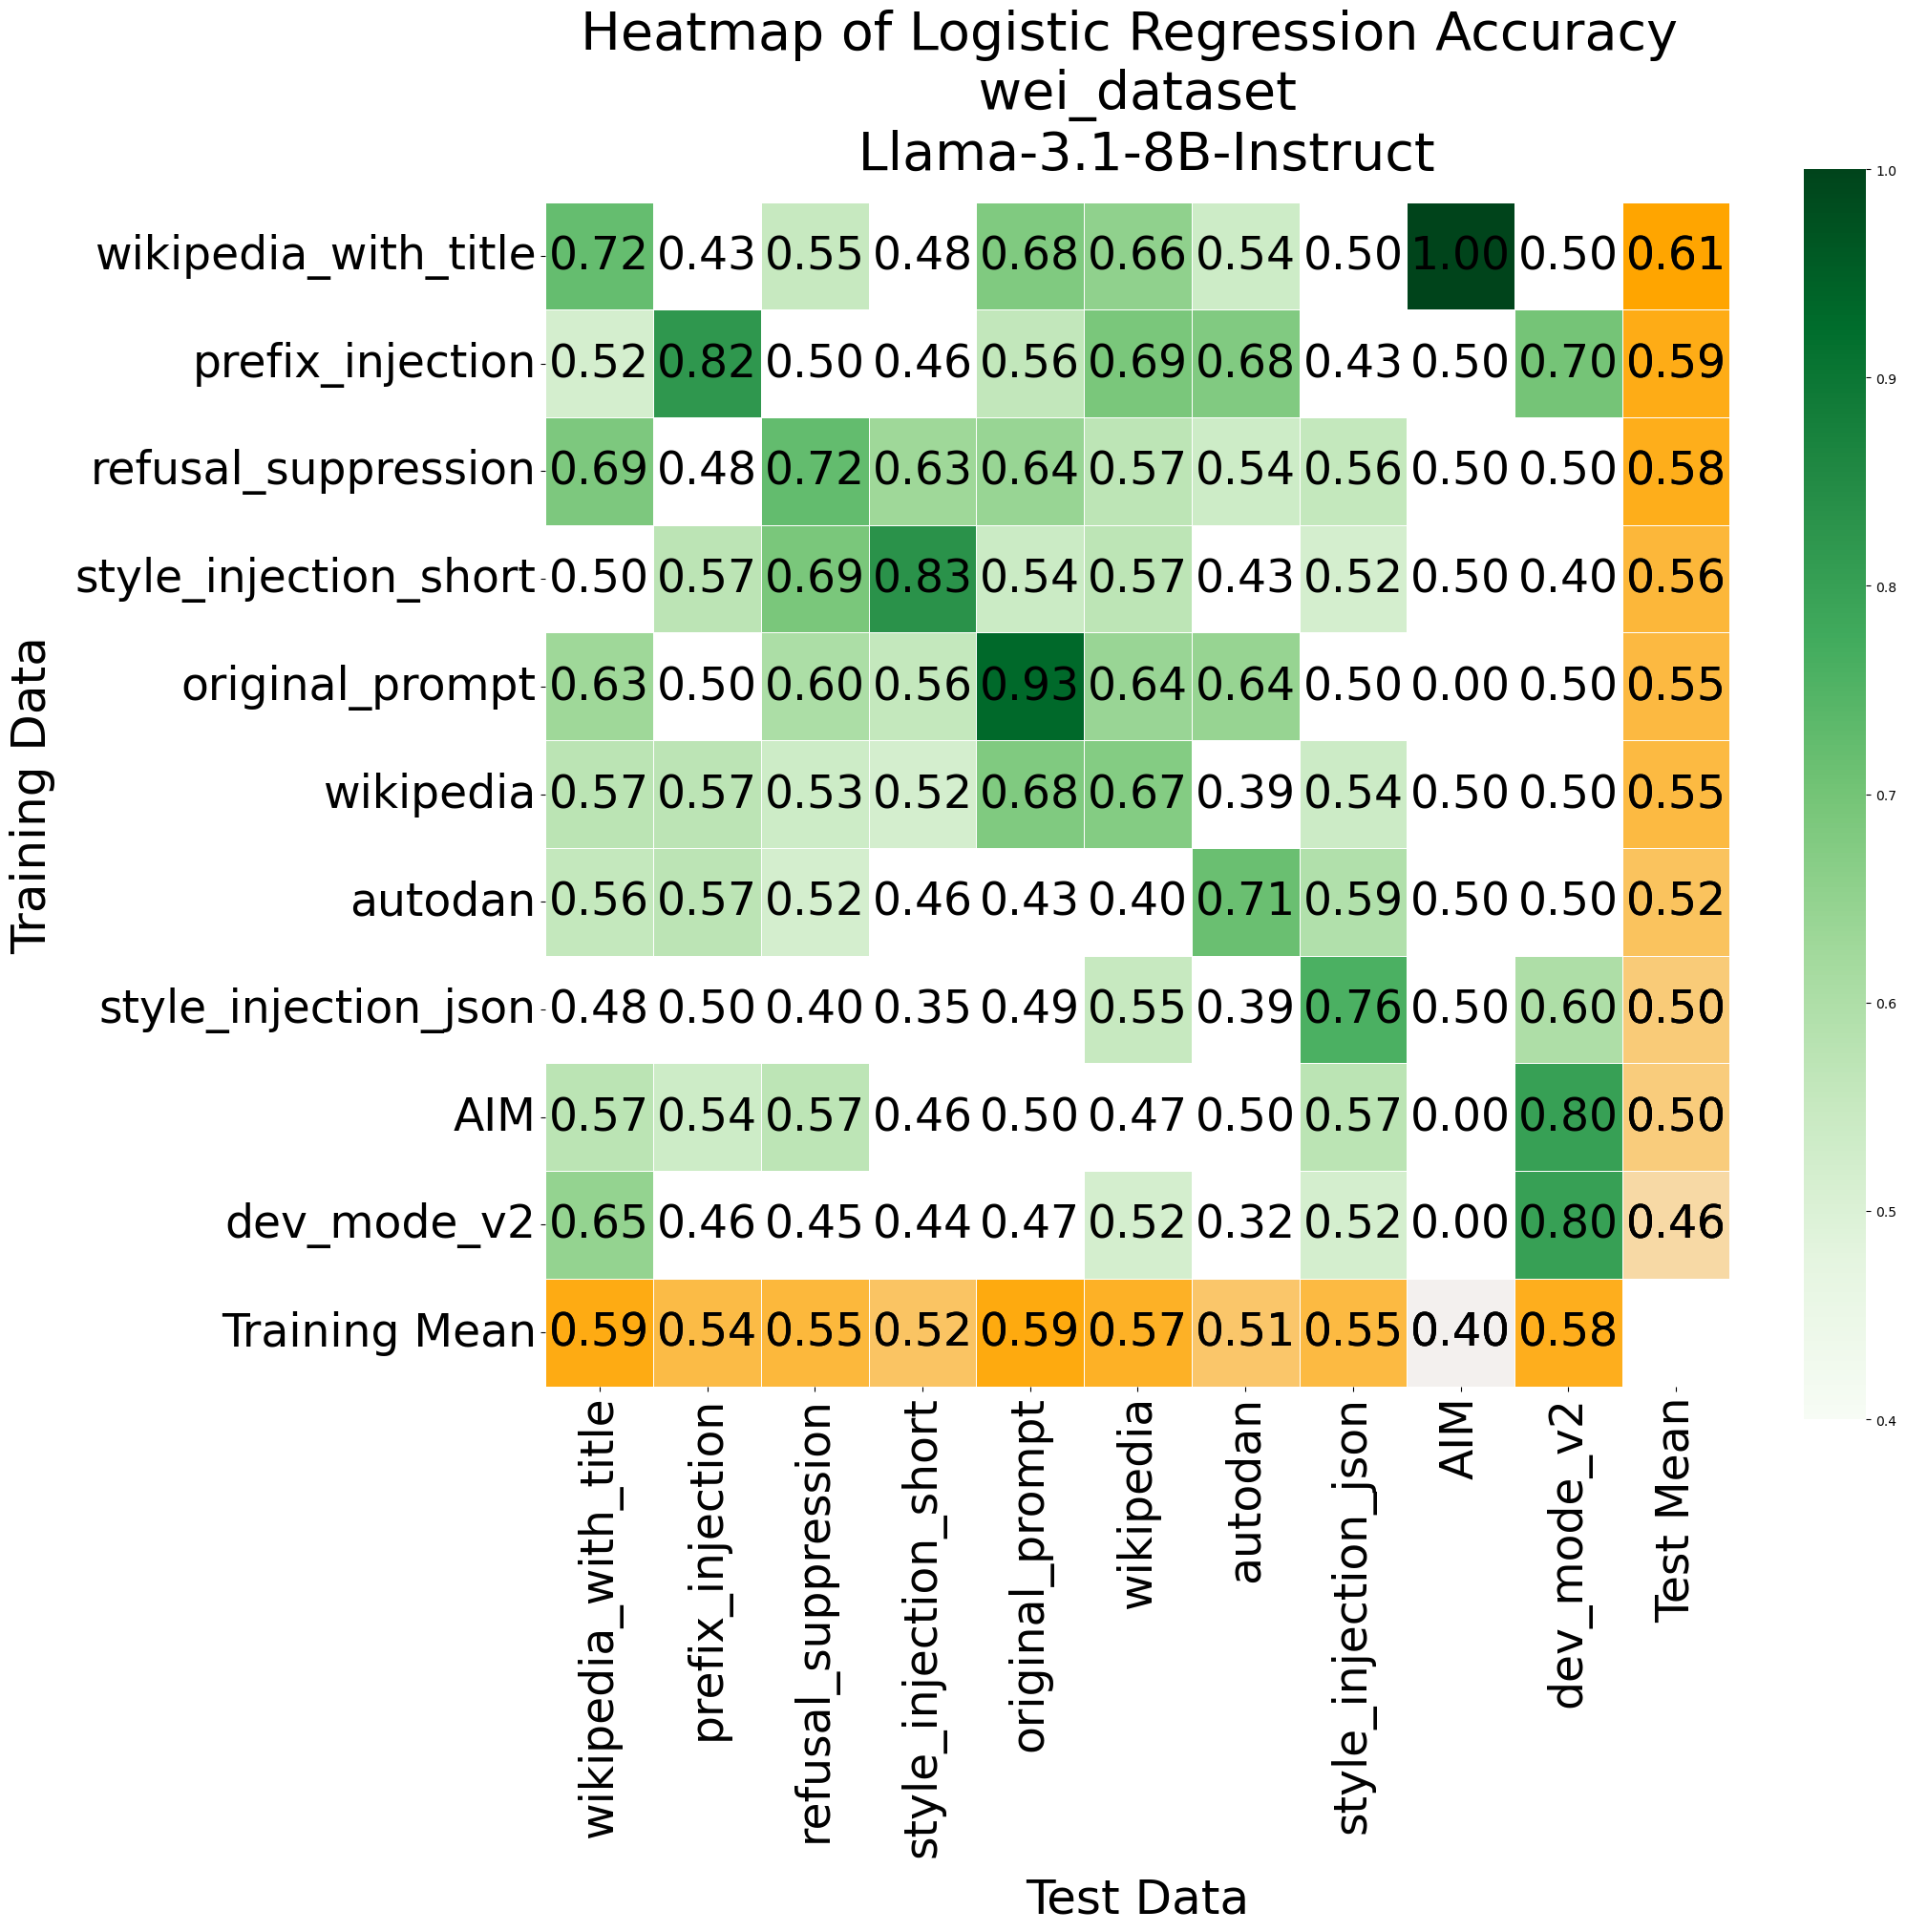

In [15]:
transfer_heatmap(results_df= results_df, dataset_name=dataset_name, model_name = model_name, probe_type = "Logistic Regression", savepath= project_root / f"images/transfer/{dataset_name}_{model_name}_layer_{layer}_linear_jbwise_transfer.pdf")


In [16]:
df[df["jailbreak_prompt_name"] == "AIM"][rating_column].value_counts()

rating_output_text
Yes    296
No       4
Name: count, dtype: int64

## Transfer with Holdout

In [17]:
# holdout_df = transfer_with_holdout(df = df, probe_type = "logistic_regression", layer = layer)
# holdout_df
  

In [18]:
holdout_df = transfer_with_holdout_with_errors(df = df, probe_type = "logistic_regression", layer = layer)


Holdout:  original_prompt
before balancing
rating_binary
1    1700
0    1000
Name: count, dtype: int64
after balancing
rating_binary
1    1000
0    1000
Name: count, dtype: int64


0.98625
0.7675
Test Accuracy: 0.7675, SE: 0.009445733163709422
Holdout:  autodan
before balancing
rating_binary
1    1718
0    1282
Name: count, dtype: int64
after balancing
rating_binary
0    1282
1    1282
Name: count, dtype: int64
0.9834227206240859
0.8284600389863548
Test Accuracy: 0.8284600389863548, SE: 0.0074449095464530855
Holdout:  wikipedia
before balancing
rating_binary
1    1803
0    1197
Name: count, dtype: int64
after balancing
rating_binary
0    1197
1    1197
Name: count, dtype: int64
0.9859007832898172
0.8204592901878914
Test Accuracy: 0.8204592901878914, SE: 0.007844186565793663
Holdout:  AIM
before balancing
rating_binary
1    1652
0    1348
Name: count, dtype: int64
after balancing
rating_binary
0    1348
1    1348
Name: count, dtype: int64
0.9833024118738405
0.7870370370370371
Test Accuracy: 0.7870370370370371, SE: 0.007884781837972301
Holdout:  style_injection_json
before balancing
rating_binary
1    1814
0    1186
Name: count, dtype: int64
after balancing
rating_

In [19]:
holdout_df

,Train Set,Test Set (Holdout),Test Set SE,Test Size,Test Set
original_prompt,0.98625,0.7675,0.009446,2000,0.986250
autodan,0.983423,0.82846,0.007445,2564,0.983423
wikipedia,0.985901,0.820459,0.007844,2394,0.985901
AIM,0.983302,0.787037,0.007885,2696,0.983302
style_injection_json,0.993147,0.802105,0.00818,2372,0.993147
style_injection_short,0.987348,0.781053,0.008491,2372,0.987348
refusal_suppression,0.98706,0.807851,0.008016,2416,0.987060
dev_mode_v2,0.983537,0.770677,0.008154,2658,0.983537
prefix_injection,0.986082,0.812757,0.00792,2426,0.986082
wikipedia_with_title,0.987179,0.817623,0.007821,2438,0.987179


In [20]:
mean_transfer = round(holdout_df["Test Set (Holdout)"].mean(),2)

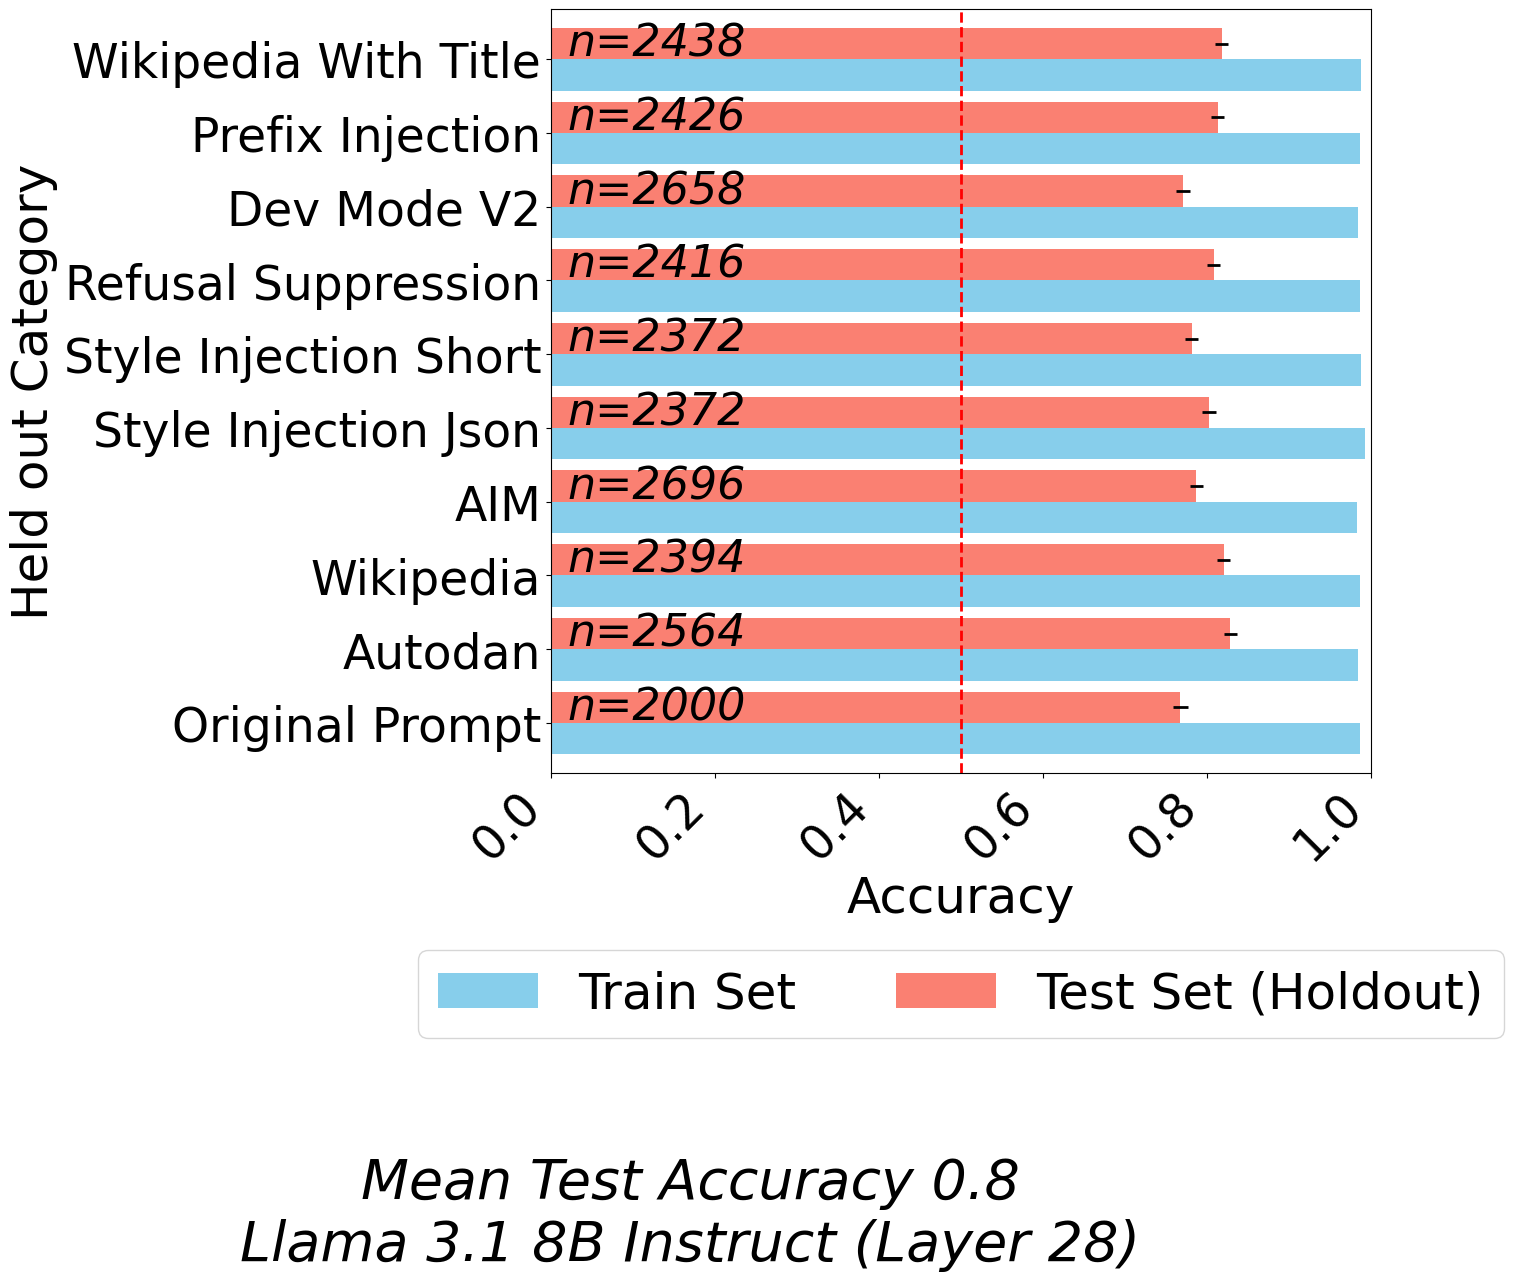

In [21]:
holdout_transfer_graph(holdout_df= holdout_df, dataset_name=dataset_name, model_name = model_name, layer = layer, probe_type = "Linear", mean_tranfer_score=mean_transfer, savepath= project_root / f"images/transfer/{dataset_name}_{model_name}_layer_{layer}_linear_holdout.pdf")

## MLP Probe

In [22]:
from analysis.supervised import *

In [23]:
results_df = probe_transfer(df = df, probe_type = "MLP", layer = layer)


results_df

rating_binary
1    248
0    248
Name: count, dtype: int64
rating_binary
0    70
1    70
Name: count, dtype: int64
rating_binary
0    145
1    145
Name: count, dtype: int64
rating_binary
1    4
0    4
Name: count, dtype: int64
rating_binary
0    134
1    134
Name: count, dtype: int64
rating_binary
0    134
1    134
Name: count, dtype: int64
rating_binary
0    144
1    144
Name: count, dtype: int64
rating_binary
0    23
1    23
Name: count, dtype: int64
rating_binary
0    139
1    139
Name: count, dtype: int64
rating_binary
1    133
0    133
Name: count, dtype: int64
PROBE TYPE MLP
PROBE TYPE MLP
PROBE TYPE MLP


PROBE TYPE MLP
PROBE TYPE MLP
PROBE TYPE MLP
PROBE TYPE MLP
PROBE TYPE MLP
PROBE TYPE MLP
PROBE TYPE MLP


,original_prompt,autodan,wikipedia,AIM,style_injection_json,style_injection_short,refusal_suppression,dev_mode_v2,prefix_injection,wikipedia_with_title
original_prompt,0.9,0.428571,0.637931,0.0,0.5,0.425926,0.706897,0.8,0.482143,0.648148
autodan,0.49,0.535714,0.568966,0.5,0.444444,0.537037,0.551724,0.5,0.553571,0.592593
wikipedia,0.72,0.535714,0.534483,0.5,0.407407,0.481481,0.431034,0.5,0.5,0.592593
AIM,0.47,0.428571,0.517241,1.0,0.37037,0.555556,0.482759,0.9,0.482143,0.462963
style_injection_json,0.44,0.607143,0.396552,0.5,0.481481,0.37037,0.5,0.5,0.571429,0.518519
style_injection_short,0.53,0.428571,0.551724,0.5,0.444444,0.574074,0.844828,0.5,0.821429,0.537037
refusal_suppression,0.49,0.571429,0.672414,0.5,0.407407,0.462963,0.448276,0.3,0.482143,0.592593
dev_mode_v2,0.5,0.607143,0.465517,0.5,0.5,0.518519,0.672414,0.7,0.535714,0.518519
prefix_injection,0.55,0.321429,0.672414,0.5,0.574074,0.537037,0.586207,0.5,0.660714,0.62963
wikipedia_with_title,0.61,0.5,0.62069,0.5,0.574074,0.462963,0.413793,0.4,0.5,0.518519


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:535: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  results_df = results_df.fillna(0)


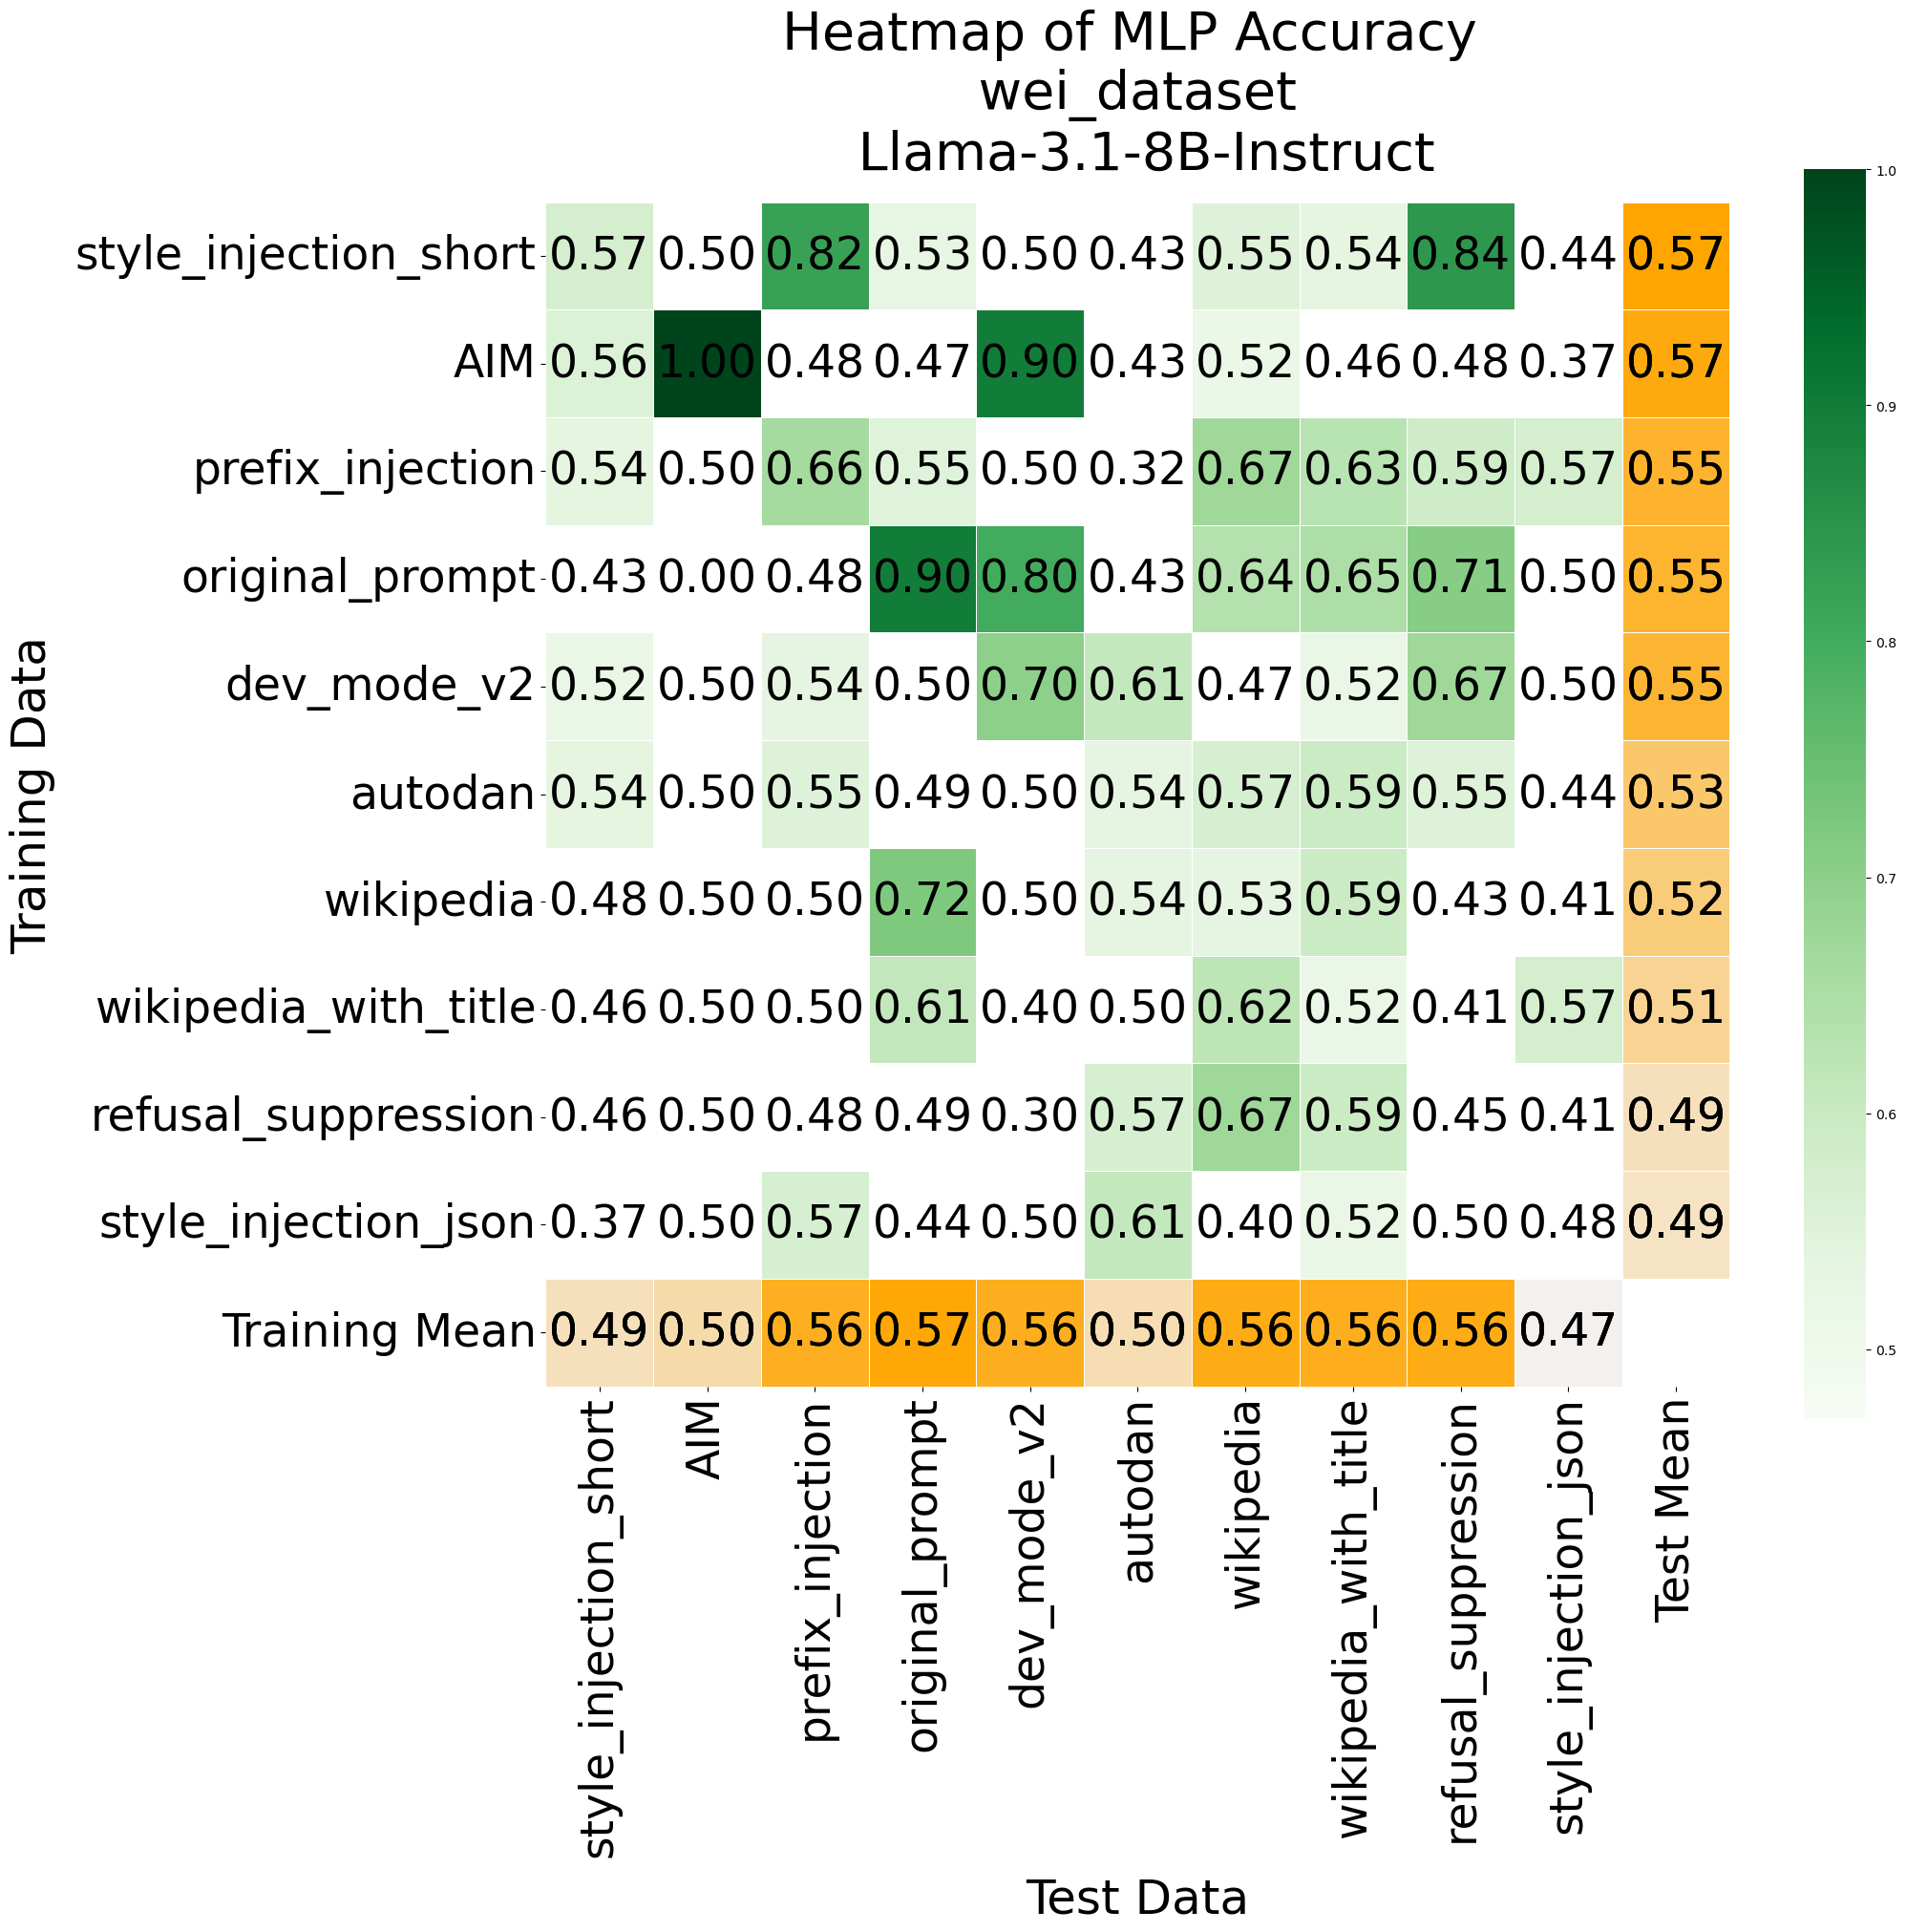

In [24]:
plot = transfer_heatmap(results_df= results_df, dataset_name=dataset_name, model_name = model_name, probe_type = "MLP", savepath= project_root / f"images/transfer/{dataset_name}_{model_name}_layer_{layer}_MLP_jbwise_transfer.pdf")

In [25]:
holdout_df = transfer_with_holdout_with_errors(df = df, probe_type = "MLP", layer = layer)


Holdout:  original_prompt
before balancing
rating_binary
1    1700
0    1000
Name: count, dtype: int64
after balancing
rating_binary
0    1000
1    1000
Name: count, dtype: int64


0.82625
0.715
Test Accuracy: 0.715, SE: 0.010093933821855581
Holdout:  autodan
before balancing
rating_binary
1    1718
0    1282
Name: count, dtype: int64
after balancing
rating_binary
0    1282
1    1282
Name: count, dtype: int64
0.8800585080448562
0.7426900584795322
Test Accuracy: 0.7426900584795322, SE: 0.008633225362176911
Holdout:  wikipedia
before balancing
rating_binary
1    1803
0    1197
Name: count, dtype: int64
after balancing
rating_binary
0    1197
1    1197
Name: count, dtype: int64
0.7577023498694517
0.6617954070981211
Test Accuracy: 0.6617954070981211, SE: 0.00966917792637566
Holdout:  AIM
before balancing
rating_binary
1    1652
0    1348
Name: count, dtype: int64
after balancing
rating_binary
1    1348
0    1348
Name: count, dtype: int64
0.8385899814471243
0.7222222222222222
Test Accuracy: 0.7222222222222222, SE: 0.008626293476970422
Holdout:  style_injection_json
before balancing
rating_binary
1    1814
0    1186
Name: count, dtype: int64
after balancing
rating_bina

In [26]:
holdout_df

,Train Set,Test Set (Holdout),Test Set SE,Test Size,Test Set
original_prompt,0.82625,0.715,0.010094,2000,0.826250
autodan,0.880059,0.74269,0.008633,2564,0.880059
wikipedia,0.757702,0.661795,0.009669,2394,0.757702
AIM,0.83859,0.722222,0.008626,2696,0.838590
style_injection_json,0.719557,0.595789,0.010076,2372,0.719557
style_injection_short,0.860833,0.72,0.009219,2372,0.860833
refusal_suppression,0.908385,0.77686,0.008471,2416,0.908385
dev_mode_v2,0.876764,0.742481,0.008481,2658,0.876764
prefix_injection,0.833505,0.703704,0.009271,2426,0.833505
wikipedia_with_title,0.788205,0.717213,0.009121,2438,0.788205


In [27]:
# get mean of holdout_df["Test Set (Holdout)"]
mean_transfer = round(holdout_df["Test Set (Holdout)"].mean(),2)

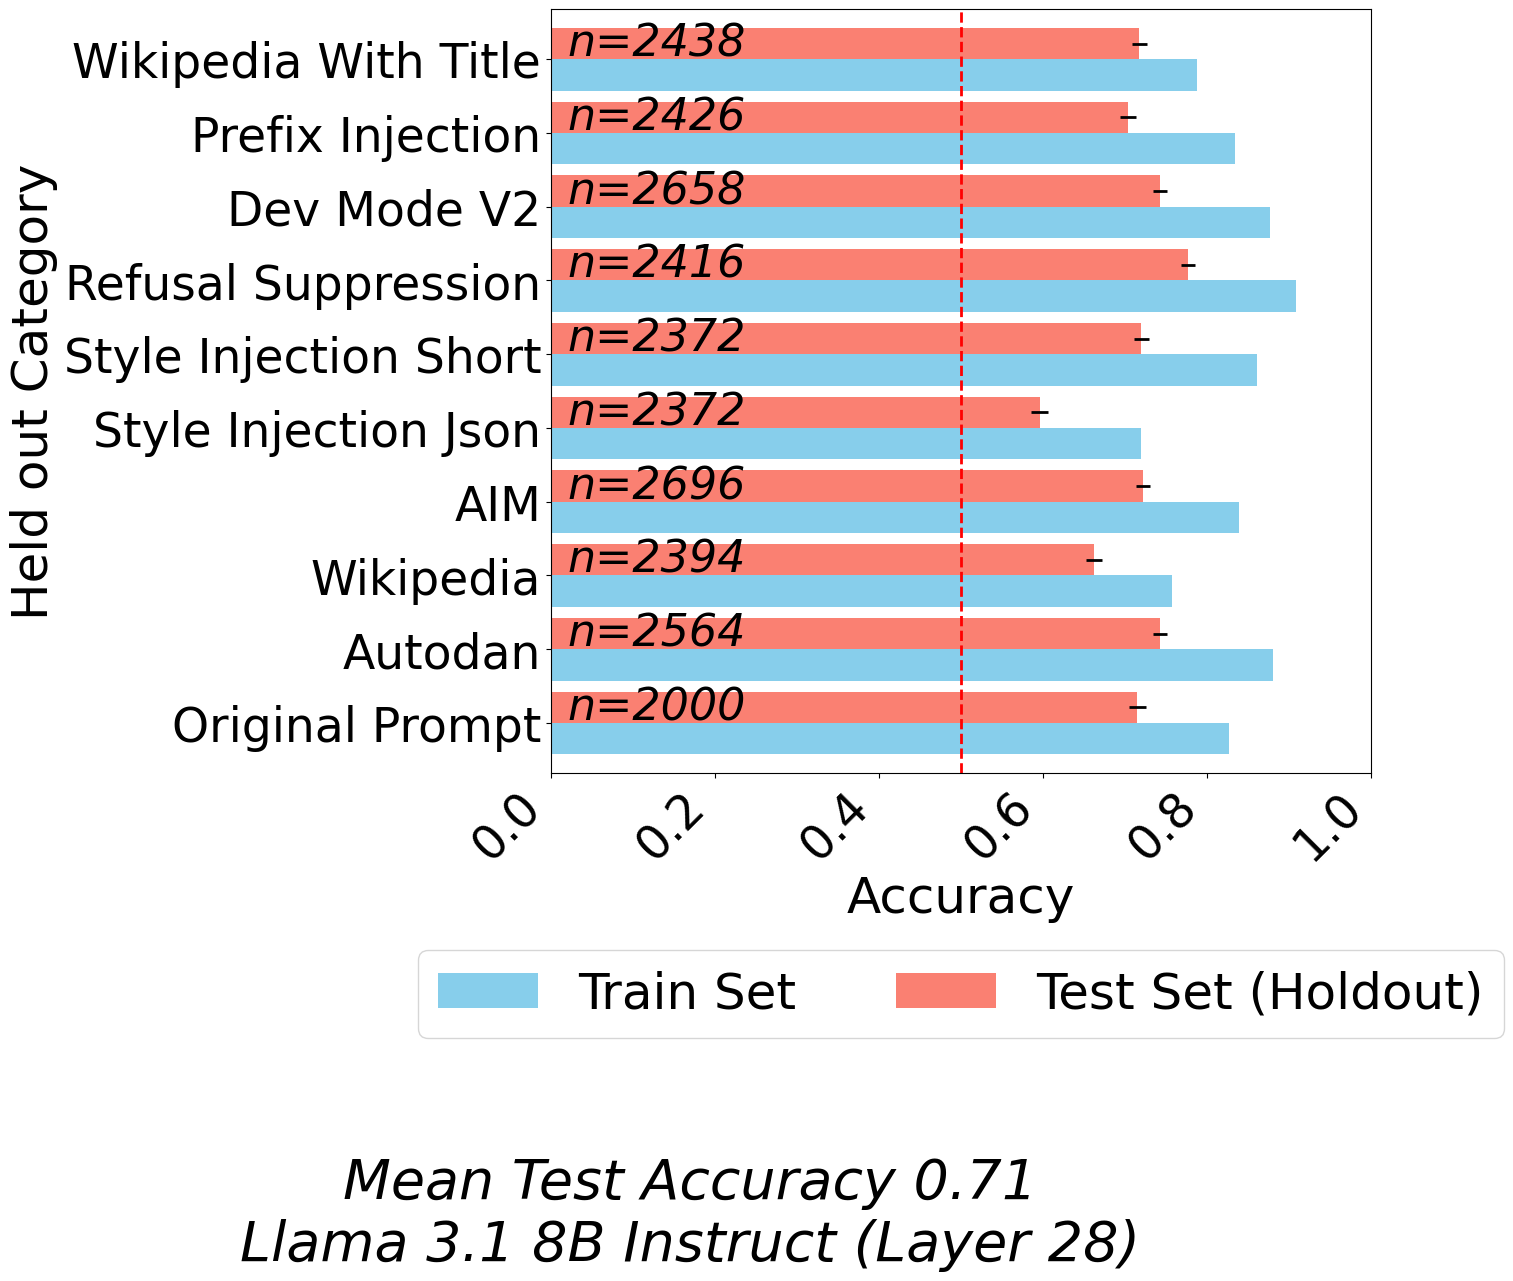

In [28]:
plot = holdout_transfer_graph(holdout_df= holdout_df, dataset_name=dataset_name, model_name = model_name, layer = layer, probe_type = "MLP", mean_tranfer_score= mean_transfer, savepath= project_root / f"images/transfer/{dataset_name}_{model_name}_layer_{layer}_MLP_holdout.pdf")

## 